In [1]:
# carga de librerias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from statsmodels.tsa.stattools import adfuller

"""
datos_ventas = ventas agrupadas por canasta 
datos_canasta = "ventas1", ventas individuales sin agrupar y contiene todos los productos comprados
datos_productos = lista de productos y sus códigos
datos_movimientos = contiene los movimientos realizados con fecha y hora x cada producto.
"""
#lectura de rutas
load_dotenv()

pth_venta = os.getenv('VENTAS')
pth_canastas = os.getenv('CANASTAS')
pth_productos = os.getenv('PRODUCTOS')
pth_movimiento = os.getenv('MOVIMIENTOS')

#lectura de archivos de ventas
datos_ventas = pd.read_excel(pth_venta)
datos_canasta = pd.read_excel(pth_canastas)
datos_productos = pd.read_excel(pth_productos)
datos_movimientos = pd.read_excel(pth_movimiento)

In [2]:
#muestra datos de canastas
datos_canasta

#datos_movimientos.head()

,EmpCod,VenNro,PrdCod,VenIteCnt,VenItePrc,VenIteIde
0,1,11,952,1.0,2000,V
1,1,11,975,3.0,1000,V
2,1,11,989,6.0,700,V
3,1,11,1178,1.0,500,V
4,1,12,111,2.0,900,V
...,...,...,...,...,...,...
244368,1,97656,1305,1.0,500,V
244369,1,97656,1687,1.0,2200,V
244370,1,97657,991,1.0,850,V
244371,1,97657,1538,1.0,500,V


In [ ]:
"""
Agrupación por canastas únicas.
CantidadProducts, se agrupan por cod. productos
"""
# se agrega la cantidad de productos agrupado
productos_canasta = datos_canasta.groupby('VenNro').agg(
    CantidadProductos=('PrdCod', 'count')
).reset_index()

print(productos_canasta.head(5))

productos_canasta.describe()

In [ ]:
"""
Filtrado de datos por cantidad de productos en canasta <=15
"""
cantidad_productos = 15
canastas_menor10productos = productos_canasta[productos_canasta['CantidadProductos'] <= cantidad_productos]
canastas_mayor10productos = productos_canasta[productos_canasta['CantidadProductos'] >= cantidad_productos]

print(f'Cantidad canastas menor a {cantidad_productos} productos:', len(canastas_menor10productos))
print(f'Cantidad canastas mayor a {cantidad_productos} productos:', len(canastas_mayor10productos))

#-------------------------- texto a mostrar 
print(f'\ndatos filtrados para menor igual a {cantidad_productos} productos')

datos_filtrados =datos_canasta[datos_canasta['VenNro'].isin(canastas_menor10productos['VenNro'])]
datos_filtrados

In [ ]:
"""
agrupación de datos por cantidad de veces comprada
y ponderación en las ventas totales

"""
# agrupar por cuántas veces se compró un producto y su acumulado

productos_agrupados = datos_filtrados.groupby('PrdCod').agg(vecesComprado=('PrdCod', 'count')).reset_index().sort_values(by = 'vecesComprado' ,ascending=False)
productos_agrupados['sumaAcumulada'] = productos_agrupados['vecesComprado'].cumsum()
productos_agrupados['porcentaje'] = (productos_agrupados['vecesComprado'].cumsum() / productos_agrupados['vecesComprado'].sum()) * 100
#print(productos_agrupados)

# top 10 productos con mayor cantidad de veces comprados
top=10
producto_top = productos_agrupados.head(top).sort_values(by='vecesComprado', ascending=False)
#.reset_index(drop=True)
print(f'Top {top} productos: ')
producto_top

In [ ]:
#selección de un producto de top 10, Red BUll
producto = producto_top['PrdCod'].astype(int).tolist()[2]
nombre_producto = datos_productos[datos_productos['PrdCod'] == producto]['PrdDsc'].values[0]
nombre_producto

### Análisis de estacionalidad

se selecciona un solo producto para realizar un análisis por día.

In [15]:
import datetime as dt

# se realiza una copia de los datos bases de movimientos
datos_movimientos_modificado = datos_movimientos.copy()

#se combina fecha y hora en una columna
datos_movimientos_modificado['timestamp'] = pd.to_datetime(datos_movimientos_modificado['MovFch'].astype(str) + ' ' + datos_movimientos_modificado['MovHor'].astype(str))
datos_movimientos_modificado['Week'] = datos_movimientos_modificado['timestamp'].dt.strftime('%U').astype(int)

# prod. más vendido
""" 
se selecciona un producto desde producto_top, top10
como prueba se realiza con redbull que es el producto[2] que corresponde al 3 producto más vendido
"""
producto = producto_top['PrdCod'].astype(int).tolist()[2]
nombre_producto = datos_productos[datos_productos['PrdCod'] == producto]['PrdDsc'].values[0]

#filtro por producto seleccionado, [2] es Redbull
producto_seleccionado = datos_movimientos_modificado[datos_movimientos_modificado['PrdCod'] == producto]

# agrupar por día
ventas_dia = producto_seleccionado.groupby(producto_seleccionado['timestamp'].dt.date)['MovCnt'].sum().reset_index(name='ventas')
print(f'Ventas por dia para {nombre_producto} :')
ventas_dia.head(5)


Ventas por dia para RED BULL 250 ML :


,timestamp,ventas
0,2020-10-02,3.0
1,2020-10-03,15.0
2,2020-10-04,16.0
3,2020-10-05,4.0
4,2020-10-06,11.0


Text(0.5, 1.0, 'RED BULL 250 ML')

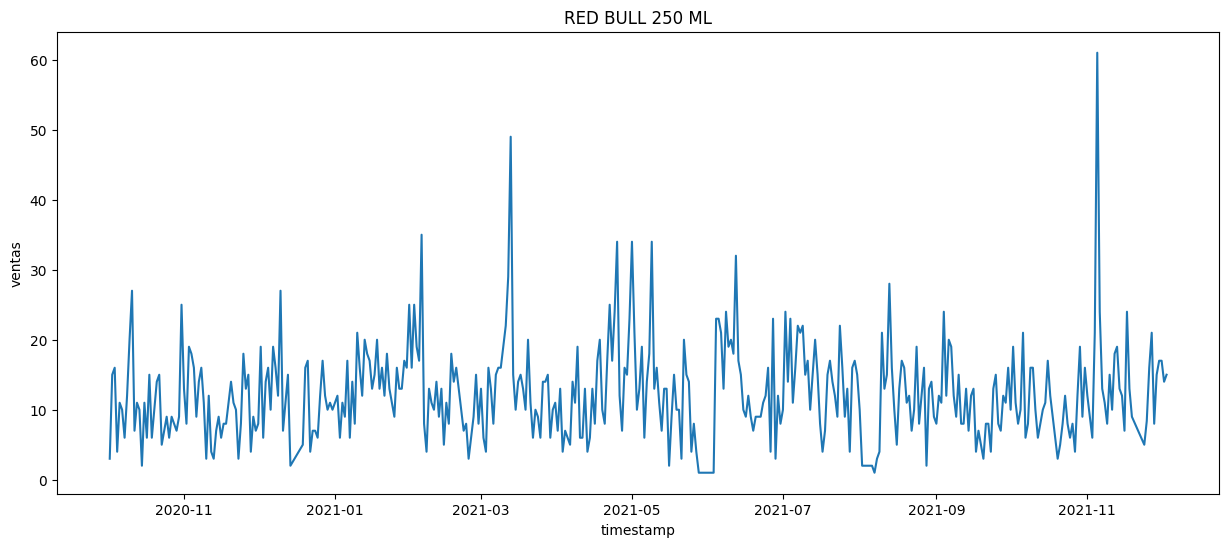

In [16]:
#graficamos ventas por día
figura_tamaño = (15,6)
fig, ax1 = plt.subplots(figsize= figura_tamaño)
sns.lineplot(data=ventas_dia, x='timestamp', y='ventas')
plt.title(f'{nombre_producto}')

### Se realiza un test estadístico para corroborar si existe o no estacionalidad:

$$H_{0} = No \; estacionario $$

Se usa Augmented Dickey-Fuller Test (ADF)

In [18]:
resultado_test = adfuller(ventas_dia['ventas'], autolag="AIC")

# Extraer resultados
adf_statistic = resultado_test[0]
p_value = resultado_test[1]
use_lag = resultado_test[2]
num_obs = resultado_test[3]
critical_values = resultado_test[4]

# mostrar resultados
print(f'ADF Estadistico: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'lag usados: {use_lag}')
print(f'numero de observaciones: {num_obs}')
print('valores críticos:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Estadistico: -14.537323314551099
p-value: 5.21350822136927e-27
lag usados: 0
numero de observaciones: 410
valores críticos:
   1%: -3.4464005219454155
   5%: -2.868615280538588
   10%: -2.570538905413444


* El p value es más pequeño que el valor significativo 0.05
* El estadístico es menor (más negativo) que los valores críticos, incluso que el 10%, lo que fortalece la evidencia contra $H_{0}$ hipótesis.
* Finalmente, se rechaza la hipótesis y si existe estacionalidad en los datos.

### Descomposición de los datos en la forma más simple:
 $ y[t] = T[t] + S[t] + e[t]$

* Tendencia, tendencia de los datos
* Seasonal, patrón cíclico encontrado
* residual; datos que no son explicados, ruido:
* Observed : datos originales

In [19]:
# se realiza la descomposición simple y se analiza en un periodo de 7 días, 1 semana como ventana de tiempo

result = sm.tsa.seasonal_decompose(ventas_dia['ventas'], model='additive', period = 7)
results_df = pd.DataFrame({'tendencia': result.trend, 'estacional': result.seasonal, 'residuos': result.resid, 'observado': result.observed})
results_df

,tendencia,estacional,residuos,observado
0,NaN,-0.711657,NaN,3.0
1,NaN,0.623318,NaN,15.0
2,NaN,1.558873,NaN,16.0
3,9.285714,0.132419,-5.418133,4.0
4,10.571429,-0.524465,0.953037,11.0
...,...,...,...,...
406,15.428571,-0.711657,0.283086,15.0
407,15.285714,0.623318,1.090968,17.0
408,NaN,1.558873,NaN,17.0
409,NaN,0.132419,NaN,14.0


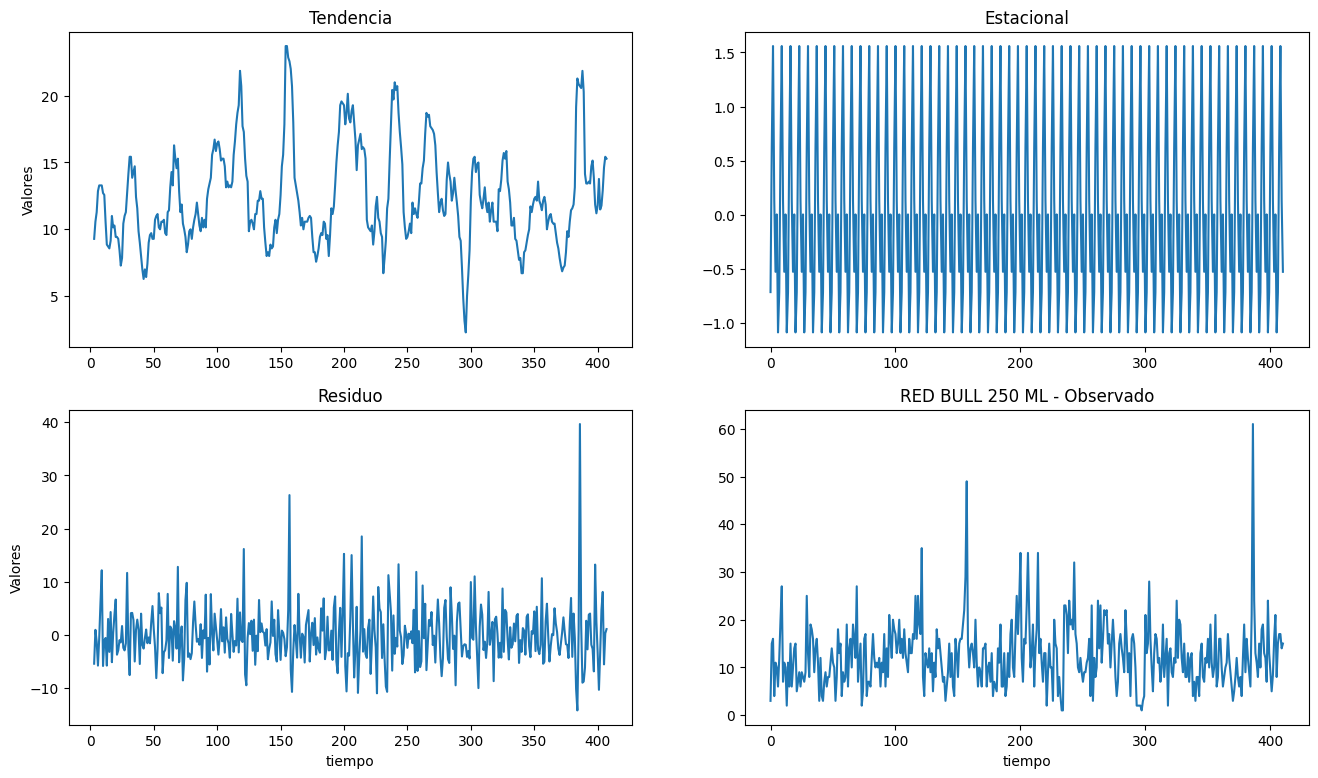

In [20]:
#Se grafica los datos de tendencia, estacionalidad, residuo, y datos originales

fig, ax = plt.subplots(ncols = 2, nrows = 2,figsize=(16,9))
df = ventas_dia
ax[0,0].plot(df.index, results_df.tendencia)
ax[0,0].set_title('Tendencia')
ax[0,0].set_ylabel('Valores')

ax[0,1].plot(df.index, results_df.estacional)
ax[0,1].set_title('Estacional')

ax[1,0].plot(df.index, results_df.residuos)
ax[1,0].set_title('Residuo')
ax[1,0].set_ylabel('Valores')
ax[1,0].set_xlabel('tiempo')

ax[1,1].plot(df.index, results_df.observado)
ax[1,1].set_title('Observado')
ax[1,1].set_xlabel('tiempo')
plt.title(f'{nombre_producto} - Observado')
plt.show()

* se detecta que existe un cierto patrón en las ventas que se repite durante las semanas = 7 días [Estacional]
* La tendencia de las ventas tiende a mantenerse con un valor medio constante. [tendencia]
* Existen periodos donde hay más o menos compras que no siguen un patron [Residuo]

<function matplotlib.pyplot.show(close=None, block=None)>

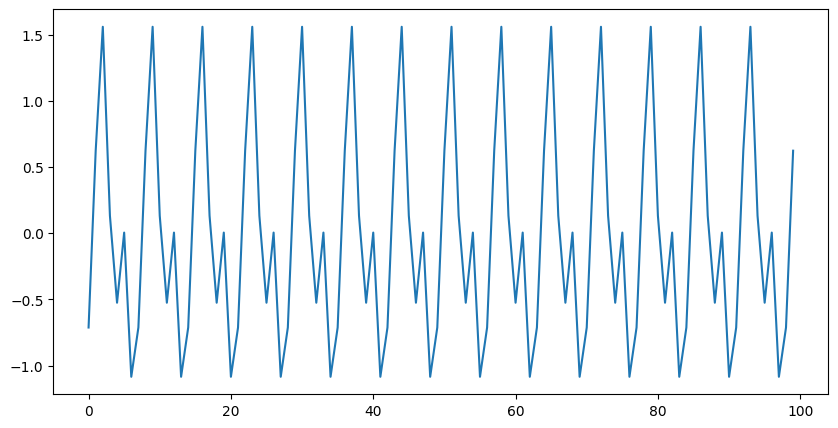

In [381]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(results_df[0:100].estacional)
plt.show

### análisis de media y varianza

Se considera la misma ventana de tiempo de 7 días para analizar

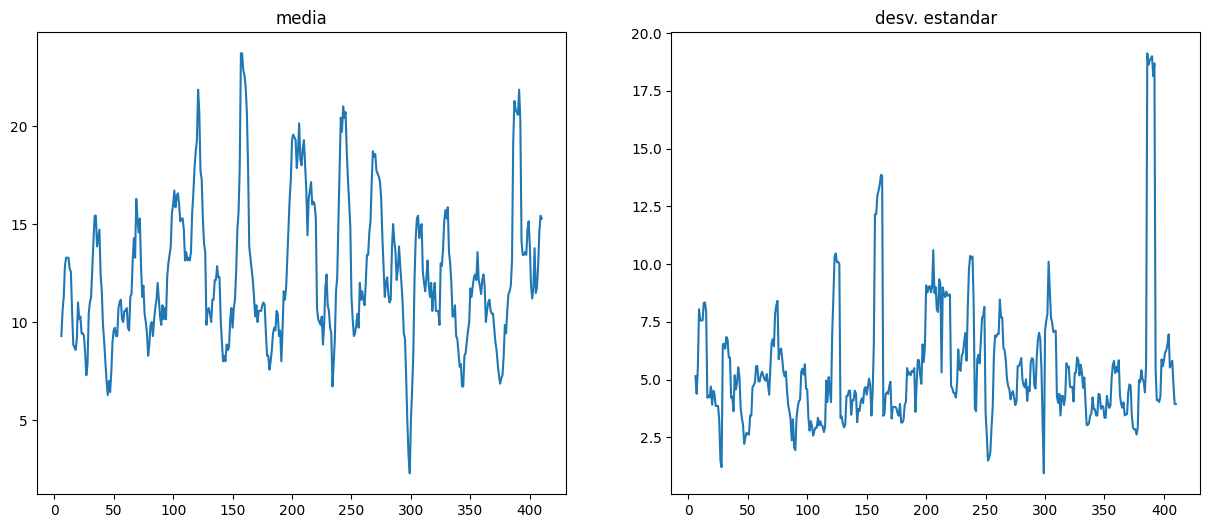

In [21]:
fig , ax= plt.subplots(1,2, figsize = figura_tamaño)
ax[0].plot(ventas_dia['ventas'].rolling(window=7).mean())
ax[0].set_title("media")
ax[1].plot(ventas_dia['ventas'].rolling(window=7).std())
ax[1].set_title('desv. estandar')
plt.show()

* Se aprecian que en ambos casos existe se mantienen bastante constrante. media y desv. estandar

In [22]:
# agrupar por semanas
ventas_semanas = producto_seleccionado.groupby('Week')['MovCnt'].sum().reset_index(name='ventas')
ventas_semanas.head(5)

,Week,ventas
0,0,12.0
1,1,71.0
2,2,117.0
3,3,107.0
4,4,95.0


Text(0.5, 1.0, 'RED BULL 250 ML')

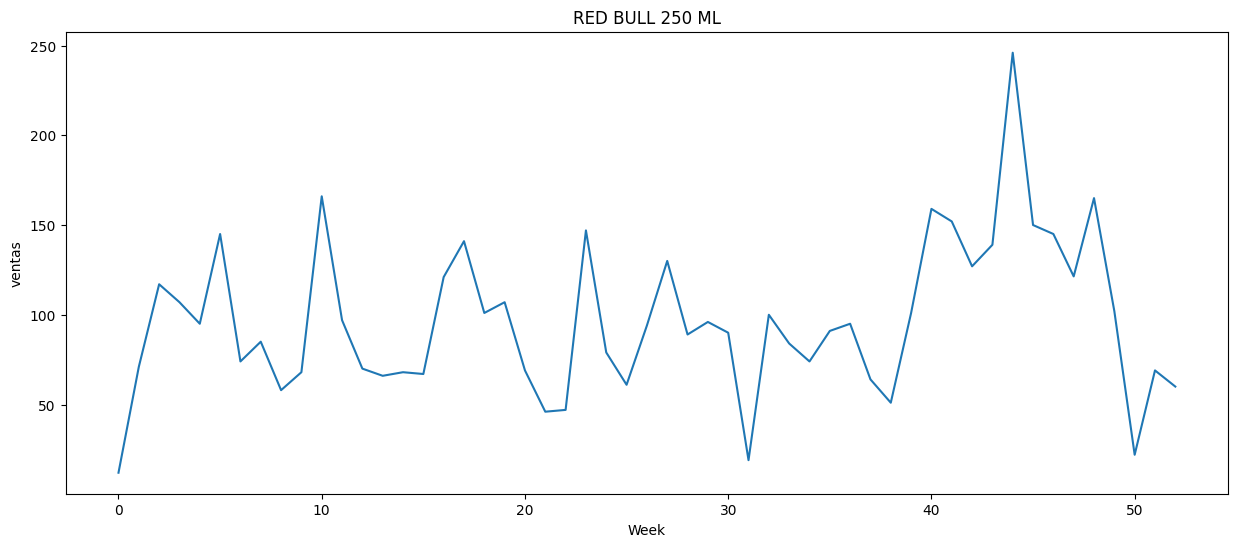

In [23]:
#graficamos
figura_tamaño = (15,6)
fig, ax1 = plt.subplots(figsize= figura_tamaño)
sns.lineplot(data=ventas_semanas, x='Week', y='ventas')
plt.title(f'{nombre_producto}')

### prueba de homogeneidad

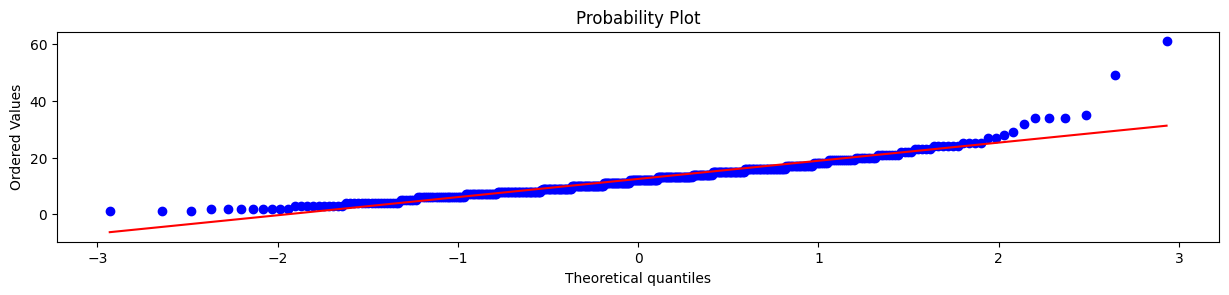

In [24]:
fig = plt.figure(figsize=figura_tamaño)

ax1 = fig.add_subplot(211)
prob = stats.probplot(ventas_dia['ventas'], dist=stats.norm, plot=ax1)

Se realiza una transformación Box-Cox para darle homogeneidad

el lambda óptimo es: 0.4060017225764735


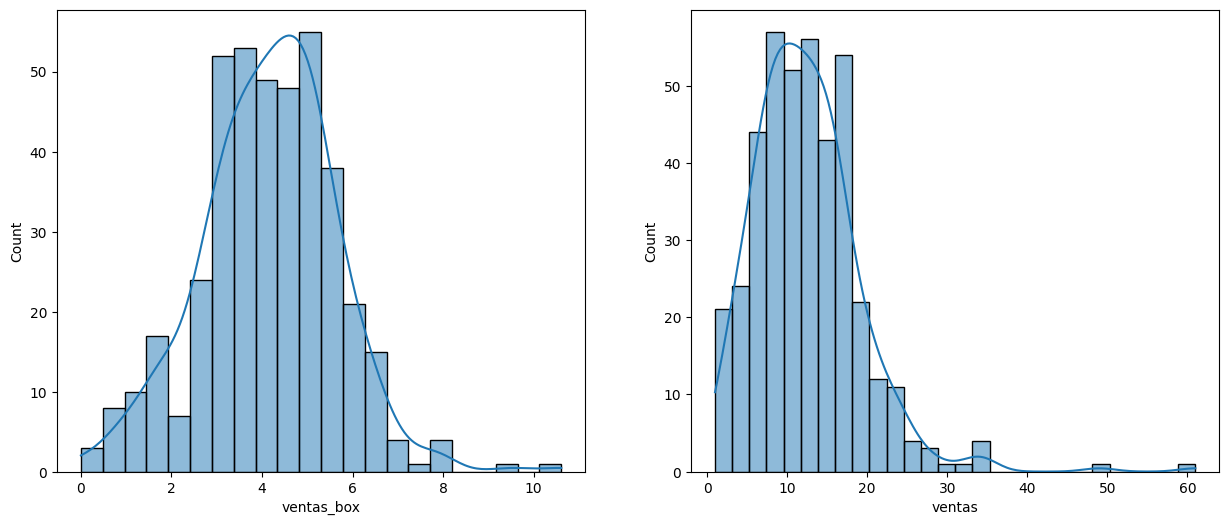

In [25]:
#se reliza la transformación agregando columna con valores nuevos
ventas_dia['ventas_box'], mejor_lambda = stats.boxcox(ventas_dia['ventas'])

#configuración figura
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figura_tamaño)

# se muestra ambas distribuciones, con y sin transformación
sns.histplot(ventas_dia['ventas_box'], kde=True, ax=ax[0])
sns.histplot(ventas_dia['ventas'], kde=True, ax=ax[1])
print(f'el lambda óptimo es: {mejor_lambda}')

Se aprecia que la fig. Derecha tiene una forma de skew con tendencia hacia la izq. Mientras que al realizar la transformación, fig. Izq. podemos verificar que esta sí tiene una dist. más perecida a una dist. normal.

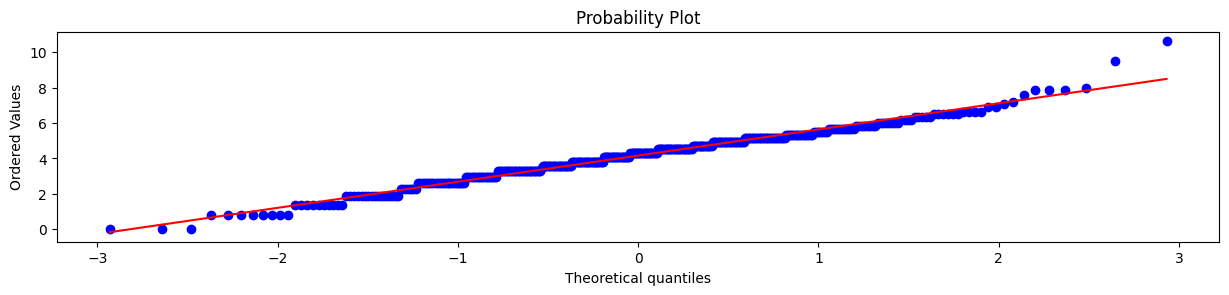

In [26]:
# se realiza la prueba visual de homogeneidad pra la transformación box-cox

fig = plt.figure(figsize=figura_tamaño)

ax1 = fig.add_subplot(211)
prob = stats.probplot(ventas_dia['ventas_box'], dist=stats.norm, plot=ax1)

Se aprecia que existe una gran mejora en la homogeneidad de la distr. de la transformación Box-Cox ❎

Se realiza un test Shapiro-Wilk donde la hipótesis inicial es que tiene normalidad.
$$ H_{o} : la \; dist. \; es \; normal$$

In [27]:
from tabulate import tabulate

res_i = stats.shapiro(ventas_dia['ventas'])
res_t = stats.shapiro(ventas_dia['ventas_box'])

print(tabulate([['Ventas', res_i.statistic, res_i.pvalue], ['Ventas-Transform.', res_t.statistic, res_t.pvalue]], headers=['datos','estadistico', 'pvalue']))

datos                estadistico       pvalue
-----------------  -------------  -----------
Ventas                  0.898394  6.51596e-16
Ventas-Transform.       0.985187  0.000328733


* Para ventas, se rechaza la hipótesis que tiene una dist. normal
* Para ventas con transformación, el estadístico es cerac de 1, y su p-value está muy cerca del valor crítico 0.05, por lo que no se puede rechazar con completa seguridad. Por lo que mantenemos nuestras dudas y a priori, tiene una dist. normal. Así que se considera verificar un test de monte carlo

###  Prueba de correlación entre los 10 top productos

### Autocorrelación

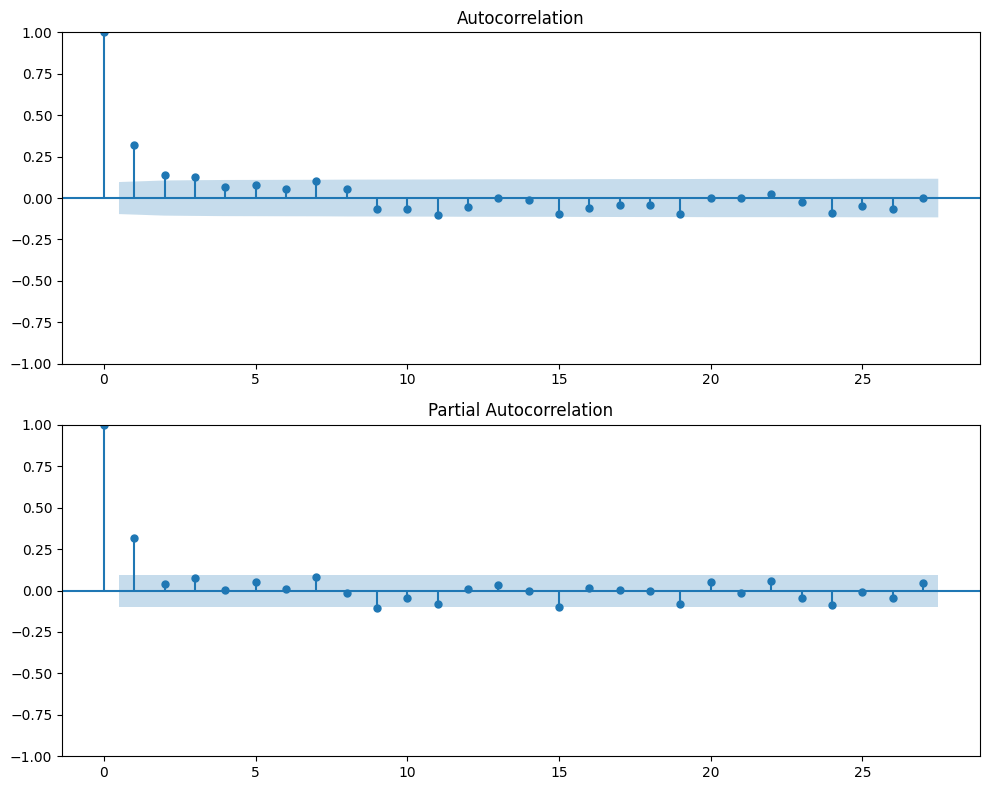

In [35]:
# se muestra el grafico para autocorrelacion  y parcial
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))
plot_acf(ventas_dia['ventas'], ax = ax1)
plot_pacf(ventas_dia['ventas'], ax = ax2)
plt.tight_layout()
plt.show()

Analizando qué tanto influencian los datos anteriores.
* Se aprecia que el lag = 1 es el que tiene mayor peso significancia.
* Los siguiente lags tienen menos influencia.


### Predicción

Se utilizará la librería Nixtla open source

In [36]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [37]:
# datos de ventas, realizamos una copia
datos_ventas_dia = ventas_dia.copy()
datos_ventas_dia = ventas_dia[["timestamp","ventas"]]
datos_ventas_dia

,timestamp,ventas
0,2020-10-02,3.0
1,2020-10-03,15.0
2,2020-10-04,16.0
3,2020-10-05,4.0
4,2020-10-06,11.0
...,...,...
406,2021-11-29,15.0
407,2021-11-30,17.0
408,2021-12-01,17.0
409,2021-12-02,14.0


In [38]:
#arreglamos formato, agramos un "unique_id"
datos_ventas_dia["unique_id"]="1"


# re ordenados y cambiamos nombres en formato standar
datos_ventas_dia.columns = ["ds","y","unique_id"]
datos_ventas_dia = datos_ventas_dia[["unique_id", "ds", "y"]]

#convertir to time stamps column = ds
datos_ventas_dia['ds'] = pd.to_datetime(datos_ventas_dia['ds'], format='%d%b%Y:%H:%M:%S.%f')
datos_ventas_dia

,unique_id,ds,y
0,1,2020-10-02,3.0
1,1,2020-10-03,15.0
2,1,2020-10-04,16.0
3,1,2020-10-05,4.0
4,1,2020-10-06,11.0
...,...,...,...
406,1,2021-11-29,15.0
407,1,2021-11-30,17.0
408,1,2021-12-01,17.0
409,1,2021-12-02,14.0


In [278]:
#objeto con los modelos y features que deseamos construir
fcst = MLForecast(
    models=[],
    freq='D',
    #lags=[1],
    #date_features=['dayofweek','week'],
    target_transforms=[Differences([2])],
)

prep1 = fcst.preprocess(datos_ventas_dia)
prep1

,unique_id,ds,y
2,1,2020-10-04,13.0
3,1,2020-10-05,-11.0
4,1,2020-10-06,-5.0
5,1,2020-10-07,6.0
6,1,2020-10-08,-5.0
...,...,...,...
406,1,2021-11-29,-6.0
407,1,2021-11-30,9.0
408,1,2021-12-01,2.0
409,1,2021-12-02,-3.0


In [78]:
from utilsforecast.plotting import plot_series

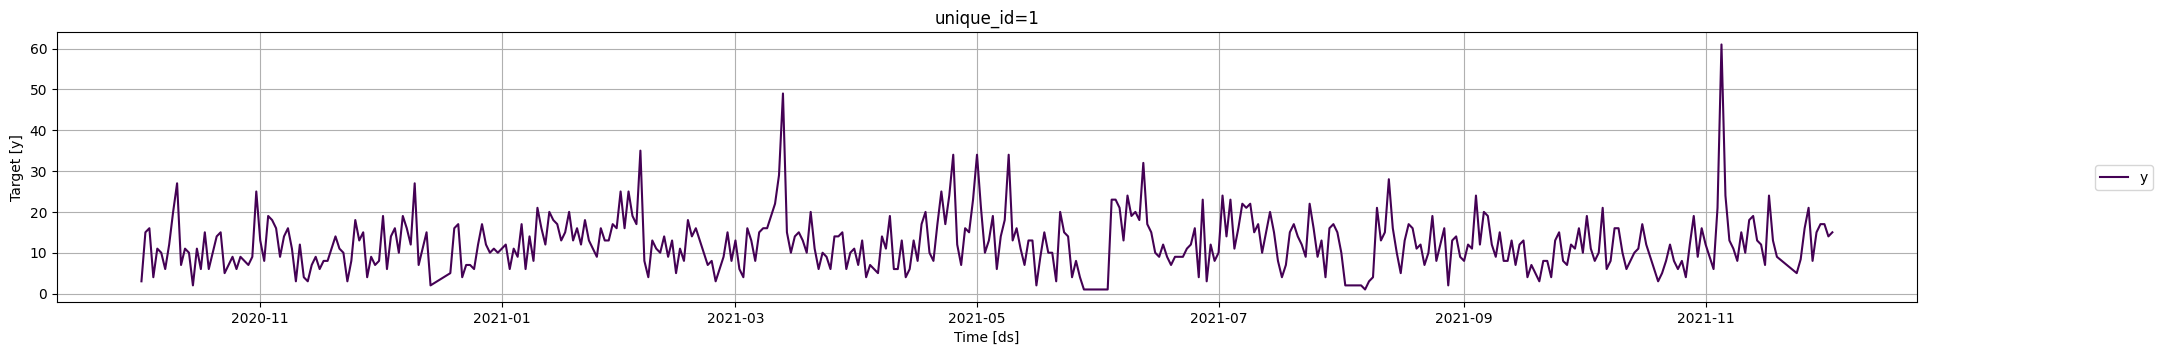

In [276]:
plot_series(datos_ventas_dia)

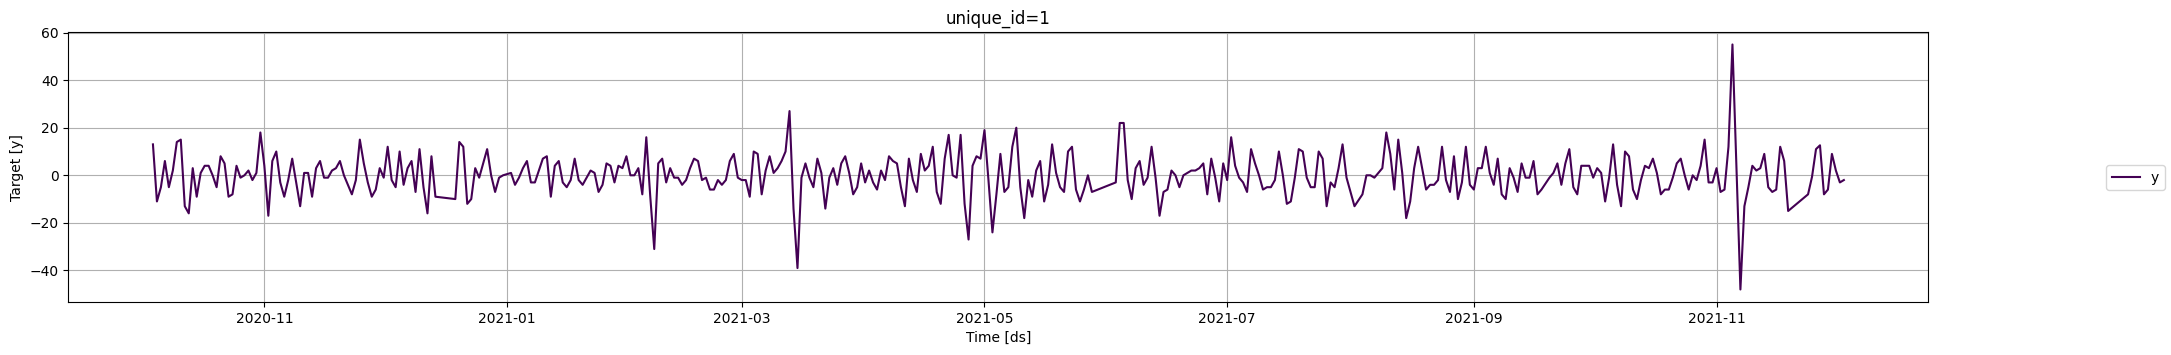

In [279]:
plot_series(prep1)


In [39]:
#modelos
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
    xgb.XGBRegressor(),
]


In [382]:
#objeto con los modelos y features que deseamos construir
mlf = MLForecast(
    models=models,
    freq='D',
    lags=[1],
    lag_transforms={
        1: [ExpandingMean()],
        #1: [RollingMean(window_size=3)]
    },
    date_features=['dayofweek','week'],
    #target_transforms=[Differences([2])],
)

prep = mlf.preprocess(datos_ventas_dia)
prep

,unique_id,ds,y,lag1,expanding_mean_lag1,dayofweek,week
1,1,2020-10-03,15.0,3.0,3.000000,5,40
2,1,2020-10-04,16.0,15.0,9.000000,6,40
3,1,2020-10-05,4.0,16.0,11.333333,0,41
4,1,2020-10-06,11.0,4.0,9.500000,1,41
5,1,2020-10-07,10.0,11.0,9.800000,2,41
...,...,...,...,...,...,...,...
406,1,2021-11-29,15.0,8.0,12.419667,0,48
407,1,2021-11-30,17.0,15.0,12.426007,1,48
408,1,2021-12-01,17.0,17.0,12.437218,2,48
409,1,2021-12-02,14.0,17.0,12.448374,3,48


Entrenamiento

In [383]:
# Entramiento
mlf.fit(datos_ventas_dia, id_col="unique_id", time_col="ds",target_col="y")
predictions = mlf.predict(14)
predictions

,unique_id,ds,LGBMRegressor,LinearRegression,XGBRegressor
0,1,2021-12-04,14.030864,13.257413,15.195328
1,1,2021-12-05,12.369753,13.285725,15.217304
2,1,2021-12-06,11.742751,10.025363,16.640249
3,1,2021-12-07,12.493625,9.613118,15.701178
4,1,2021-12-08,12.295309,10.031543,14.769122
5,1,2021-12-09,11.460249,10.691905,15.874624
6,1,2021-12-10,12.097669,11.422400,13.406399
7,1,2021-12-11,13.643555,12.172896,12.642914
8,1,2021-12-12,12.500209,12.928768,11.105789
9,1,2021-12-13,11.569981,9.880751,13.617609


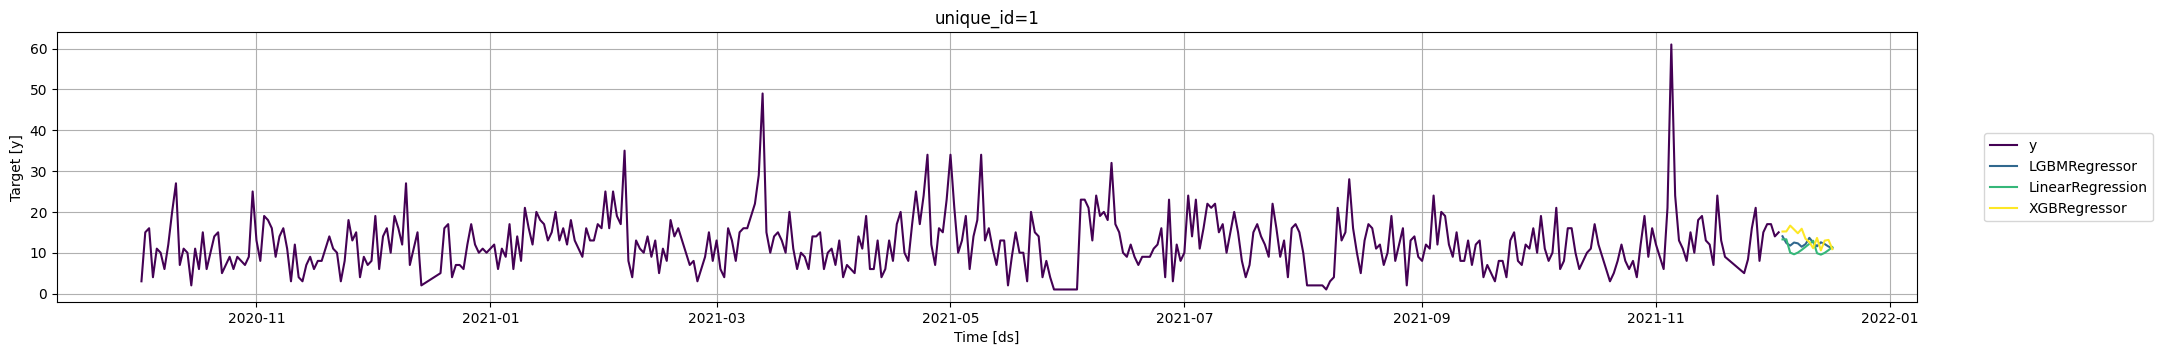

In [384]:
plot_series(datos_ventas_dia, predictions, max_ids=1, plot_random=False)

usando crosvalidation para corrborar los modelos

In [386]:
crossvalidation_df = mlf.cross_validation(
    df=datos_ventas_dia,
    id_col="unique_id",
    time_col="ds",
    h=14,
    n_windows=10,
)

def plot_cv(df, df_cv, uid, fname, last_n=14 * 24):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(20, 30), gridspec_kw=dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        df.query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='XGBRegressor')
    fig.savefig(fname, bbox_inches='tight')
    plt.show()

In [358]:
crossvalidation_df.head()


,unique_id,ds,cutoff,y,LGBMRegressor,LinearRegression,XGBRegressor
0,1,2021-09-25,2021-09-24,15.0,10.912611,11.964022,10.930844
1,1,2021-09-26,2021-09-24,8.0,12.835784,12.744889,15.379412
2,1,2021-09-27,2021-09-24,7.0,5.495157,10.168229,6.409419
3,1,2021-09-28,2021-09-24,12.0,9.202916,10.087890,9.030537
4,1,2021-09-29,2021-09-24,11.0,9.355446,10.478507,10.933023


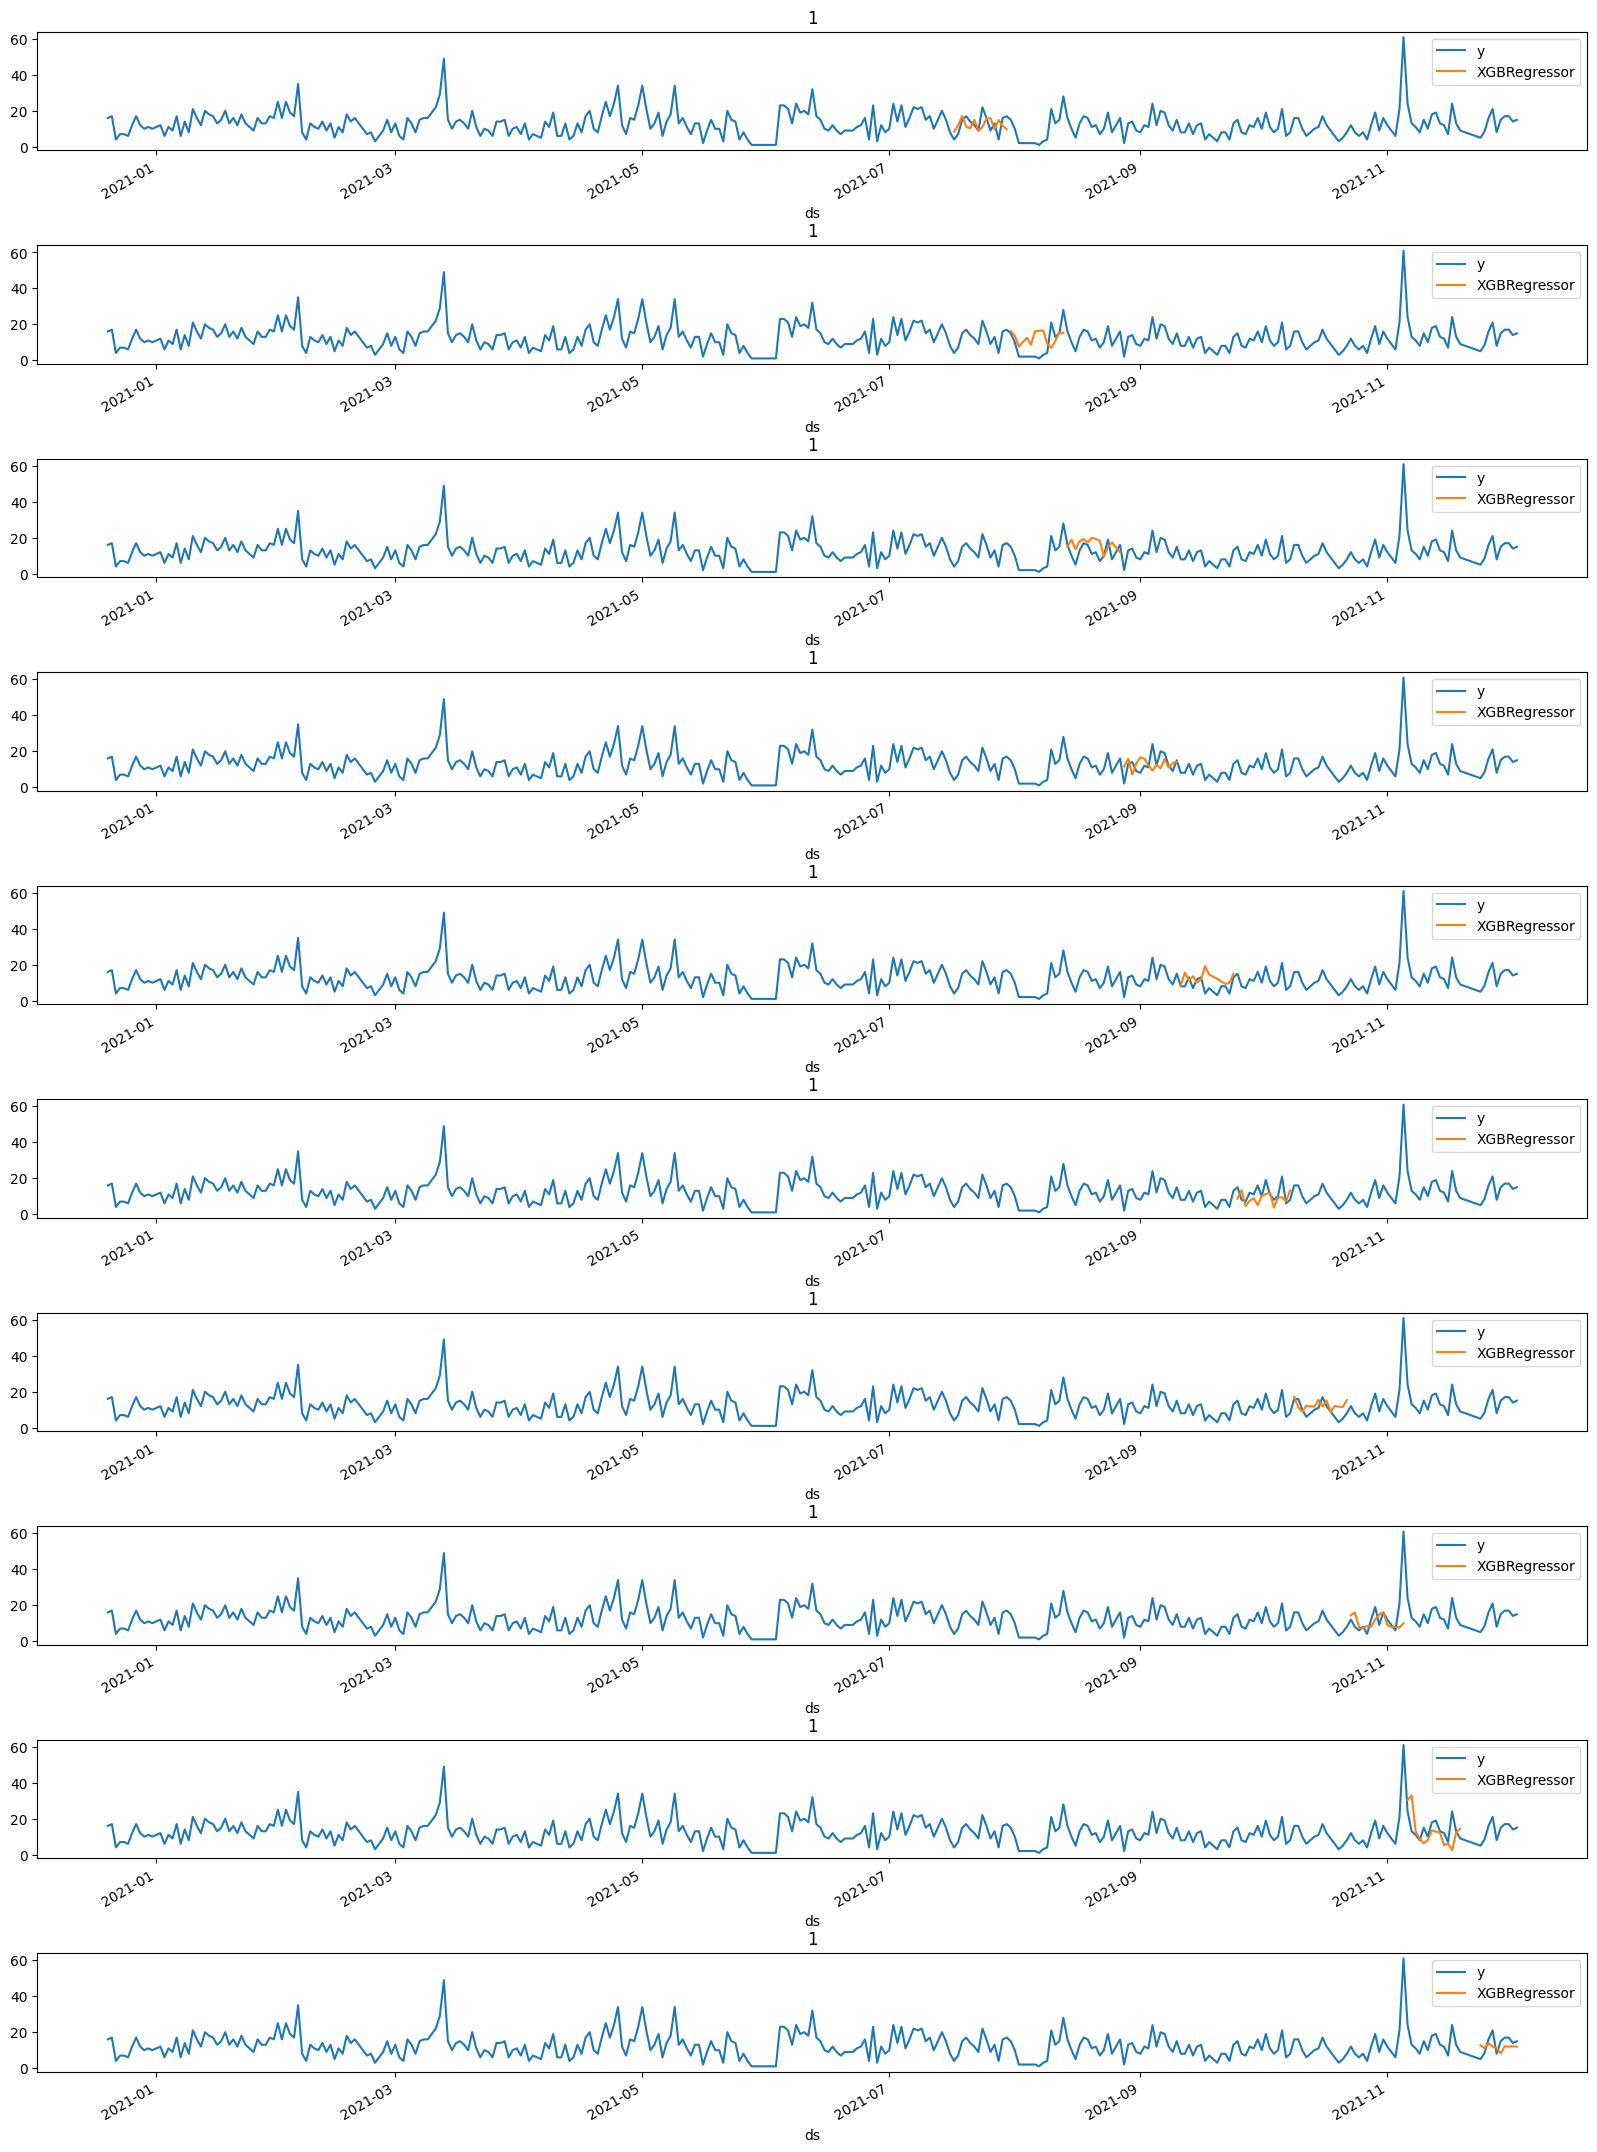

In [387]:
plot_cv(datos_ventas_dia, crossvalidation_df, '1', 'cross_validation__predictions.png')


In [441]:

#from datasetsforecast.losses import mae, mape, mase, rmse, smape
from utilsforecast.losses import rmse, mae, mse

In [442]:

def evaluate_cv(df):
    modelos = ["LGBMRegressor", "LinearRegression", "XGBRegressor"]
    resultados_rmse = []
    for xModelo in modelos:
        resultados_rmse.append([xModelo, 
                                rmse(df, models=[xModelo], id_col='cutoff').set_index('cutoff').mean().values[0],
                                mae(df, models=[xModelo], id_col='cutoff').set_index('cutoff').mean().values[0],
                                mse(df, models=[xModelo], id_col='cutoff').set_index('cutoff').mean().values[0]
                                ])
    return resultados_rmse

evaluacion_modelos = evaluate_cv(crossvalidation_df)
pd.DataFrame(evaluacion_modelos, columns=['nombre','rmse', 'mae','mse'])




,nombre,rmse,mae,mse
0,LGBMRegressor,6.539220,4.958269,52.532992
1,LinearRegression,6.264207,4.743551,48.028456
2,XGBRegressor,7.436740,5.556943,63.110086


### ARIMA